In [2]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torchmetrics
from tqdm import tqdm
import torchaudio
from datasets import load_dataset, DatasetDict
import numpy as np
import random


/home/pierre/Documents/Projects/PST4/AI/.venv/lib64/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED = 42
SAMPLE_RATE = 16000
BATCH_SIZE = 32
NUM_WORKERS = 23
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

In [4]:
ds = load_dataset("Usernameeeeee/df_462700_2")

ds_split = ds["train"].train_test_split(test_size=0.3, seed=SEED, shuffle=True)
test_and_valid = ds_split["test"].train_test_split(test_size=0.5, seed=SEED, shuffle=True)

ds = DatasetDict({
    "train": ds_split["train"],
    "valid": test_and_valid["train"],
    "test": test_and_valid["test"],
})

print("Dataset splits:", {k: v.shape for k, v in ds.items()})

Dataset splits: {'train': (323890, 3), 'valid': (69405, 3), 'test': (69406, 3)}


In [ ]:
# -----------------------------
# Audio transforms
# -----------------------------
mel_transform = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=2048,
    hop_length=256,
    n_mels=64,
)
db_transform = torchaudio.transforms.AmplitudeToDB()

In [6]:
# -----------------------------
# Collate function with Mel computation
# -----------------------------
# Define augmentations
augmentations = torch.nn.Sequential(
    torchaudio.transforms.Vol(gain=random.uniform(-5, 5)),
)

def collate_fn(batch):
    xs, ys = [], []

    for b in batch:
        waveform = torch.tensor(b["audio"]).float()

        if waveform.ndim > 1:
            waveform = waveform.mean(dim=0)
        #
        # # Apply waveform-level augmentation
        # if random.random() < 0.5:  # 50% chance
        #     # Example augmentations
        #     if random.random() < 0.5:
        #         waveform = torchaudio.transforms.FrequencyMasking(freq_mask_param=15)(waveform.unsqueeze(0)).squeeze(0)
        #     if random.random() < 0.5:
        #         waveform = torchaudio.transforms.TimeMasking(time_mask_param=35)(waveform.unsqueeze(0)).squeeze(0)
        #     if random.random() < 0.3:
        #         waveform = waveform + 0.005 * torch.randn_like(waveform)  # Add noise

        mel = mel_transform(waveform)
        mel_db = db_transform(mel)

        xs.append(mel_db)
        ys.append(b["label"])

    max_len = max(x.shape[-1] for x in xs)
    xs_padded = torch.zeros((len(xs), 1, 64, max_len))
    for i, x in enumerate(xs):
        xs_padded[i, 0, :, :x.shape[-1]] = x

    return xs_padded, torch.tensor(ys).float().unsqueeze(1)
train_loader = DataLoader(ds["train"], batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
valid_loader = DataLoader(ds["valid"], batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, collate_fn=collate_fn)
test_loader = DataLoader(ds["test"], batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS, collate_fn=collate_fn)

/home/pierre/Documents/Projects/PST4/AI/.venv/lib64/python3.13/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 23 worker processes in total. Our suggested max number of worker in current system is 16, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SEBlock(nn.Module):
    def __init__(self, c, r=8):
        super().__init__()
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(c, c // r, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(c // r, c, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        w = self.pool(x).view(b, c)
        w = self.fc(w).view(b, c, 1, 1)
        return x * w

class DepthwiseSeparableConv(nn.Module):
    def __init__(self, in_ch, out_ch, k=3, s=1, p=1):
        super().__init__()
        self.depth = nn.Conv2d(in_ch, in_ch, k, s, p, groups=in_ch, bias=False)
        self.point = nn.Conv2d(in_ch, out_ch, 1, bias=False)
        self.bn = nn.BatchNorm2d(out_ch)
        self.act = nn.PReLU()

    def forward(self, x):
        x = self.depth(x)
        x = self.point(x)
        x = self.bn(x)
        return self.act(x)

class SpectralTemporalAttention(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.freq_fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((None, 1)),
            nn.Conv2d(channels, channels, 1),
            nn.Sigmoid()
        )
        self.time_fc = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, None)),
            nn.Conv2d(channels, channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        freq_att = self.freq_fc(x)
        time_att = self.time_fc(x)
        return x * freq_att * time_att

class DroneAudioCNN(nn.Module):
    def __init__(self, n_classes=1, freq_bins=128):
        super().__init__()
        self.layer1 = DepthwiseSeparableConv(1, 16)
        self.layer2 = DepthwiseSeparableConv(16, 32)
        self.se1 = SEBlock(32)
        self.layer3 = DepthwiseSeparableConv(32, 64)
        self.se2 = SEBlock(64)
        self.att = SpectralTemporalAttention(64)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Linear(64, 64),
            nn.BatchNorm1d(64),
            nn.PReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, n_classes)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = F.max_pool2d(x, 2)
        x = self.layer2(x)
        x = F.max_pool2d(x, 2)
        x = self.se1(x)
        x = self.layer3(x)
        x = self.se2(x)
        x = self.att(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)

model = DroneAudioCNN().to(DEVICE)

In [11]:
# -----------------------------
# Loss, optimizer, metric
# -----------------------------
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
metric_acc = torchmetrics.classification.BinaryAccuracy().to(DEVICE)

In [12]:
# -----------------------------
# Training loop
# -----------------------------
EPOCHS = 5
best_val_acc = 0

for epoch in range(EPOCHS):
    model.train()
    train_loss, train_acc = 0, 0

    for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Train]"):
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)
        train_acc += metric_acc(out, y) * x.size(0)

    scheduler.step()
    train_loss /= len(ds["train"])
    train_acc /= len(ds["train"])

    # Validation
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.no_grad():
        for x, y in tqdm(valid_loader, desc=f"Epoch {epoch+1}/{EPOCHS} [Valid]"):
            x, y = x.to(DEVICE), y.to(DEVICE)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item() * x.size(0)
            val_acc += metric_acc(out, y) * x.size(0)

    val_loss /= len(ds["valid"])
    val_acc /= len(ds["valid"])

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | "
          f"Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_simple_cnn.pt")
        print("✅ Saved new best model!")

Epoch 1/5 [Valid]: 100%|██████████| 2169/2169 [00:25<00:00, 85.51it/s] 


Epoch 1/5 | Train Loss: 0.1637 | Train Acc: 0.9395 | Val Loss: 0.0736 | Val Acc: 0.9728
✅ Saved new best model!


Epoch 2/5 [Valid]: 100%|██████████| 2169/2169 [00:25<00:00, 86.01it/s] 


Epoch 2/5 | Train Loss: 0.0724 | Train Acc: 0.9748 | Val Loss: 0.0475 | Val Acc: 0.9842
✅ Saved new best model!


Epoch 3/5 [Valid]: 100%|██████████| 2169/2169 [00:25<00:00, 86.74it/s] 


Epoch 3/5 | Train Loss: 0.0552 | Train Acc: 0.9814 | Val Loss: 0.0392 | Val Acc: 0.9869
✅ Saved new best model!


Epoch 4/5 [Valid]: 100%|██████████| 2169/2169 [00:24<00:00, 87.02it/s] 


Epoch 4/5 | Train Loss: 0.0461 | Train Acc: 0.9847 | Val Loss: 0.0366 | Val Acc: 0.9882
✅ Saved new best model!


Epoch 5/5 [Valid]: 100%|██████████| 2169/2169 [00:25<00:00, 86.47it/s] 

Epoch 5/5 | Train Loss: 0.0415 | Train Acc: 0.9865 | Val Loss: 0.0350 | Val Acc: 0.9883
✅ Saved new best model!


In [13]:
# Load model
model = DroneAudioCNN().to(DEVICE)
model.load_state_dict(torch.load("best_simple_cnn.pt", map_location=DEVICE))
model.eval()
print("✅ Loaded best model and set to eval mode")

✅ Loaded best model and set to eval mode


In [14]:
all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        logits = model(x)
        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).float()  # Threshold 0.5

        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())      # append batch probabilities
        all_labels.extend(y.cpu().numpy().flatten())  #

Testing: 100%|██████████| 2169/2169 [00:27<00:00, 77.57it/s] 


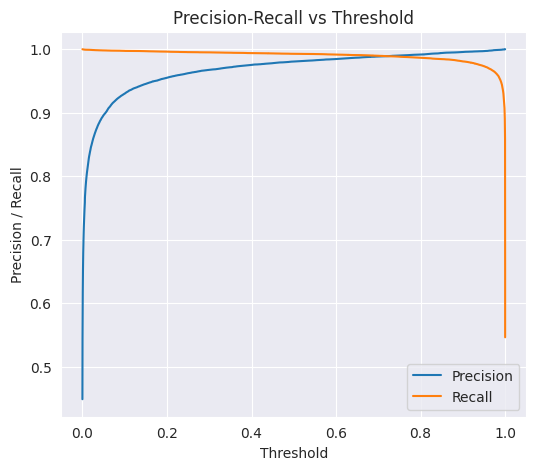

In [15]:
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt

labels = np.array(all_labels)
probs = np.array(all_probs)

precision, recall, thresholds = precision_recall_curve(labels, probs)

# Plot Precision-Recall
plt.figure(figsize=(6,5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Precision / Recall")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.show()


In [22]:
# -----------------------------
# Metrics
# -----------------------------
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

df_results = pd.DataFrame({
    "true_label": all_labels,
    "pred_label": all_preds,
    "confidence": all_probs
})

accuracy = accuracy_score(all_labels, all_preds)
print(f"✅ Test Accuracy: {accuracy*100:.2f}%")

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=ds["train"].features["label"].names, digits=3))

cm = confusion_matrix(all_labels, all_preds)
print("\nConfusion Matrix:")
print(cm)

✅ Test Accuracy: 98.79%

Classification Report:
              precision    recall  f1-score   support

       other      0.994     0.984     0.989     38272
       drone      0.981     0.993     0.987     31134

    accuracy                          0.988     69406
   macro avg      0.987     0.988     0.988     69406
weighted avg      0.988     0.988     0.988     69406


Confusion Matrix:
[[37659   613]
 [  224 30910]]


In [ ]:
def infer_from_dataset_binary(model, dataset, threshold=0.5, drone_only=False, other_only=False):
    results = []

    test_dataset_labels = dataset.features["label"].names
    training_labels = ds["train"].features["label"].names

    for item in tqdm(dataset, desc="Inference"):
        if test_dataset_labels[item["label"]] != "drone" and drone_only:
            continue
        if test_dataset_labels[item["label"]] != "other" and other_only:
            continue

        waveform = torch.tensor(item["audio"]["array"]).float()
        if waveform.ndim > 1:
            waveform = waveform.mean(dim=0)

        # Compute Mel + dB on the fly
        mel = mel_transform(waveform)
        mel_db = db_transform(mel).unsqueeze(0).unsqueeze(0).to(DEVICE)

        with torch.no_grad():
            logits = model(mel_db)
            prob = torch.sigmoid(logits).item()
            pred_label = training_labels[1] if prob > threshold else training_labels[0]

        true_label = test_dataset_labels[item["label"]]

        results.append({
            "true_label": true_label,
            "pred_label": pred_label,
            "confidence": round(prob, 3)
        })

    df_results = pd.DataFrame(results)
    accuracy = (df_results["true_label"] == df_results["pred_label"]).mean()
    print(f"\n✅ Accuracy on ds_test_online: {accuracy*100:.2f}% {'(Drone only)' if drone_only else ''}")

    return df_results

In [24]:
ds_test_online = load_dataset("Usernameeeeee/drone_test", split="test")
df_test_results = infer_from_dataset_binary(model, ds_test_online, drone_only=False)

Inference: 100%|██████████| 893/893 [00:01<00:00, 672.46it/s]


✅ Accuracy on ds_test_online: 67.41% 


In [28]:
ds_test_online = load_dataset("Usernameeeeee/drone_test_2", split="test")
df_test_results = infer_from_dataset_binary(model, ds_test_online, drone_only=False)

Inference: 100%|██████████| 2805/2805 [00:04<00:00, 664.16it/s]


✅ Accuracy on ds_test_online: 34.65% 
